In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import pandas as pd

# Load the training and test datasets
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

# Display the first few rows of the training data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# Fill missing values in 'Age' with the median
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)

# Fill missing values in 'Fare' with the median
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)

# Fill missing values in 'Embarked' with the mode (most frequent value)
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)

# Drop the 'Cabin' column because it has too many missing values
train_df.drop(columns=['Cabin'], inplace=True)
test_df.drop(columns=['Cabin'], inplace=True)

/tmp/ipykernel_36/1990120099.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
/tmp/ipykernel_36/1990120099.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [7]:
# Encode 'Sex' (0 for male, 1 for female)
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})

# Encode 'Embarked' (0 for S, 1 for C, 2 for Q)
train_df['Embarked'] = train_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
test_df['Embarked'] = test_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

In [9]:
# Create 'FamilySize' feature
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

# Extract 'Title' from names
train_df['Title'] = train_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test_df['Title'] = test_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

# Replace rare titles with 'Other'
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
train_df['Title'] = train_df['Title'].replace(rare_titles, 'Other')
test_df['Title'] = test_df['Title'].replace(rare_titles, 'Other')

# Map titles to numerical values
title_mapping = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Other': 4}
train_df['Title'] = train_df['Title'].map(title_mapping)
test_df['Title'] = test_df['Title'].map(title_mapping)

In [10]:
# Select features for clustering
features_for_clustering = train_df[['Pclass', 'Age', 'Fare', 'FamilySize']]

# Now check for missing values
print(features_for_clustering.isnull().sum())

Pclass        0
Age           0
Fare          0
FamilySize    0
dtype: int64


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


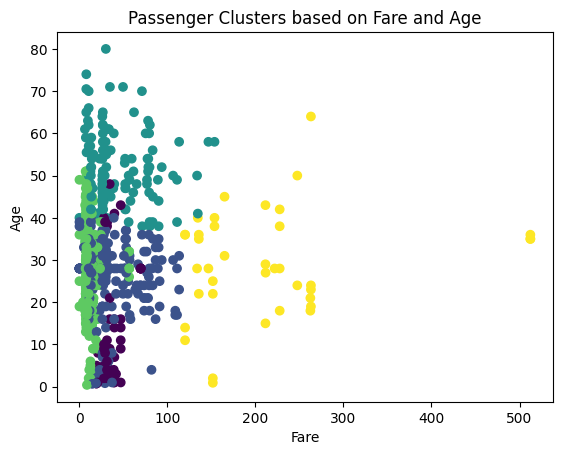

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardize the features for clustering
scaler = StandardScaler()
features_for_clustering_scaled = scaler.fit_transform(train_df[['Pclass', 'Age', 'Fare', 'FamilySize']])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
train_df['Cluster'] = kmeans.fit_predict(features_for_clustering_scaled)

# Apply the same scaling and clustering to the test set
test_features_scaled = scaler.transform(test_df[['Pclass', 'Age', 'Fare', 'FamilySize']])
test_df['Cluster'] = kmeans.predict(test_features_scaled)

# Visualize the clusters (optional, for understanding the distribution)
plt.scatter(train_df['Fare'], train_df['Age'], c=train_df['Cluster'], cmap='viridis')
plt.xlabel('Fare')
plt.ylabel('Age')
plt.title('Passenger Clusters based on Fare and Age')
plt.show()


In [17]:
# Fill missing values in 'Title' with the most common value in both train and test sets
X_train['Title'] = X_train['Title'].fillna(X_train['Title'].mode()[0])
X_test['Title'] = X_test['Title'].fillna(X_test['Title'].mode()[0])

# Check again for missing values (should be 0 now)
print(X_train.isnull().sum())
print(X_test.isnull().sum())

# Now proceed with training the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_split=5, random_state=42)

# Evaluate the model using cross-validation
scores = cross_val_score(rf_model, X_train, y_train, cv=5)

# Print cross-validation scores and the mean accuracy
print(f'Cross-validation scores: {scores}')
print(f'Mean accuracy: {scores.mean() * 100:.2f}%')


/tmp/ipykernel_36/3964698345.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Title'] = X_train['Title'].fillna(X_train['Title'].mode()[0])
/tmp/ipykernel_36/3964698345.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Title'] = X_test['Title'].fillna(X_test['Title'].mode()[0])


Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
FamilySize    0
Title         0
Cluster       0
dtype: int64
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
FamilySize    0
Title         0
Cluster       0
dtype: int64
Cross-validation scores: [0.83798883 0.80337079 0.88764045 0.80898876 0.83707865]
Mean accuracy: 83.50%


In [13]:
# Check for missing values in X_train
print(X_train.isnull().sum())


Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
FamilySize    0
Title         5
Cluster       0
dtype: int64


In [14]:
# Fill missing values in 'Title' with the most common value (or with 'Other')
X_train['Title'].fillna(X_train['Title'].mode()[0], inplace=True)
X_test['Title'].fillna(X_test['Title'].mode()[0], inplace=True)

# Check again for missing values
print(X_train.isnull().sum())


/tmp/ipykernel_36/1123634169.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['Title'].fillna(X_train['Title'].mode()[0], inplace=True)
/tmp/ipykernel_36/1123634169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Title'].fillna(X_train['Title'].mode()[0], inplace=True)


NameError: name 'X_test' is not defined

In [16]:
# Create X_test by selecting relevant features
X_test = test_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title', 'Cluster']]

# Fill missing values in 'Title' with the most common value (or 'Other')
X_test['Title'] = X_test['Title'].fillna(X_test['Title'].mode()[0])

/tmp/ipykernel_36/1598290495.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Title'] = X_test['Title'].fillna(X_test['Title'].mode()[0])


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameters grid to search
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the best score
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_ * 100:.2f}%")


Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END max_depth=5, min_samples_lea

In [19]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=300, max_depth=10, learning_rate=0.05, random_state=42)

# Cross-validation for XGBoost
scores = cross_val_score(xgb_model, X_train, y_train, cv=5)

# Print cross-validation results
print(f'XGBoost cross-validation scores: {scores}')
print(f'Mean accuracy: {scores.mean() * 100:.2f}%')


XGBoost cross-validation scores: [0.81564246 0.80337079 0.84831461 0.79213483 0.80337079]
Mean accuracy: 81.26%


In [20]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Initialize models
logreg = LogisticRegression()
rf = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)
xgb_model = xgb.XGBClassifier(n_estimators=300, max_depth=10, learning_rate=0.05, random_state=42)

# Combine them using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('lr', logreg),
    ('rf', rf),
    ('xgb', xgb_model)
], voting='soft')

# Cross-validation for the ensemble model
scores = cross_val_score(ensemble_model, X_train, y_train, cv=5)

print(f'Ensemble model cross-validation scores: {scores}')
print(f'Mean accuracy: {scores.mean() * 100:.2f}%')
 

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Ensemble model cross-validation scores: [0.83240223 0.8258427  0.86516854 0.81460674 0.85393258]
Mean accuracy: 83.84%


In [22]:
# Create age bins
train_df['AgeBin'] = pd.cut(train_df['Age'], bins=[0, 12, 20, 40, 60, 80], labels=[0, 1, 2, 3, 4])
test_df['AgeBin'] = pd.cut(test_df['Age'], bins=[0, 12, 20, 40, 60, 80], labels=[0, 1, 2, 3, 4])


In [23]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base models
estimators = [
    ('rf', RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)),
    ('xgb', xgb.XGBClassifier(n_estimators=300, max_depth=10, learning_rate=0.05, random_state=42))
]

# Define Stacking model with Logistic Regression as meta-model
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Cross-validation for the stacking model
scores = cross_val_score(stacking_model, X_train, y_train, cv=5)

print(f'Stacking model cross-validation scores: {scores}')
print(f'Mean accuracy: {scores.mean() * 100:.2f}%')


Stacking model cross-validation scores: [0.83240223 0.80898876 0.86516854 0.80898876 0.84269663]
Mean accuracy: 83.16%


In [24]:
# Create a new feature combining Pclass and Fare
X_train['Pclass_Fare'] = X_train['Pclass'] * X_train['Fare']
X_test['Pclass_Fare'] = X_test['Pclass'] * X_test['Fare']


/tmp/ipykernel_36/2276908858.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Pclass_Fare'] = X_train['Pclass'] * X_train['Fare']
/tmp/ipykernel_36/2276908858.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Pclass_Fare'] = X_test['Pclass'] * X_test['Fare']


In [25]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
scores = cross_val_score(rf_model, X_train, y_train, cv=skf)

print(f'StratifiedKFold cross-validation scores: {scores}')
print(f'Mean accuracy: {scores.mean() * 100:.2f}%')


StratifiedKFold cross-validation scores: [0.82681564 0.79775281 0.87640449 0.78089888 0.80898876]
Mean accuracy: 81.82%


In [26]:
# Re-train the best Random Forest model from GridSearchCV
best_rf_model = RandomForestClassifier(
    n_estimators=200, max_depth=20, min_samples_leaf=2, min_samples_split=10, random_state=42
)

# Train the model on the entire training set
best_rf_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, random_state=42)

In [27]:
# Make predictions on the test set
test_predictions = best_rf_model.predict(X_test)

# Create a submission DataFrame
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_predictions
})


In [28]:
# Save the submission to a CSV file
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully.")


Submission file created successfully.


In [29]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Paramètres possibles pour XGBoost
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.01, 0.1, 1]
}

# Initialiser XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)

# Randomized Search avec 5-fold cross-validation
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=20, cv=5, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres et la meilleure précision
print(f"Best hyperparameters: {random_search.best_params_}")
print(f"Best cross-validation accuracy: {random_search.best_score_ * 100:.2f}%")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}
Best cross-validation accuracy: 83.73%


In [30]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

# Initialiser LightGBM
lgb_model = lgb.LGBMClassifier(n_estimators=300, max_depth=10, learning_rate=0.05, random_state=42)

# Validation croisée sur LightGBM
scores = cross_val_score(lgb_model, X_train, y_train, cv=5)

print(f'LightGBM cross-validation scores: {scores}')
print(f'Mean accuracy: {scores.mean() * 100:.2f}%')


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 340
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [31]:
# Binning Age and Fare
train_df['FareBin'] = pd.cut(train_df['Fare'], bins=[0, 8, 15, 31, 1000], labels=[0, 1, 2, 3])
test_df['FareBin'] = pd.cut(test_df['Fare'], bins=[0, 8, 15, 31, 1000], labels=[0, 1, 2, 3])

train_df['AgeBin'] = pd.cut(train_df['Age'], bins=[0, 12, 20, 40, 60, 80], labels=[0, 1, 2, 3, 4])
test_df['AgeBin'] = pd.cut(test_df['Age'], bins=[0, 12, 20, 40, 60, 80], labels=[0, 1, 2, 3, 4])


In [32]:
# Interaction entre Pclass et Fare
train_df['Pclass_Fare'] = train_df['Pclass'] * train_df['Fare']
test_df['Pclass_Fare'] = test_df['Pclass'] * test_df['Fare']


[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=15, n_estimators=100, reg_alpha=1, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=15, n_estimators=500, reg_alpha=1, reg_lambda=0.1, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=500, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=500, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=10, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=300, reg_alpha=0.01, reg_lambda=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n

In [33]:
# Séparation des données en fonction du sexe
train_femmes = train_df[train_df['Sex'] == 1]  # Femmes
train_hommes = train_df[train_df['Sex'] == 0]  # Hommes

test_femmes = test_df[test_df['Sex'] == 1]
test_hommes = test_df[test_df['Sex'] == 0]


In [35]:
# Vérifier les valeurs manquantes dans X_train_femmes
print(X_train_femmes.isnull().sum())


Pclass         0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
FamilySize     0
Title          5
FareBin        0
AgeBin         0
Pclass_Fare    0
dtype: int64


In [37]:
# Réentraîner le modèle après avoir traité les NaN
rf_model_femmes.fit(X_train_femmes, y_train_femmes)

# Prédictions pour les femmes
predictions_femmes = rf_model_femmes.predict(X_test_femmes)


In [40]:
# Séparation des données en fonction du sexe
train_hommes = train_df[train_df['Sex'] == 0]  # Hommes
test_hommes = test_df[test_df['Sex'] == 0]

# Sélection des features pour les hommes
X_train_hommes = train_hommes[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title', 'FareBin', 'AgeBin', 'Pclass_Fare']]
y_train_hommes = train_hommes['Survived']

X_test_hommes = test_hommes[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title', 'FareBin', 'AgeBin', 'Pclass_Fare']]


In [41]:
# Remplir les valeurs manquantes dans 'Age' et 'Fare'
X_train_hommes['Age'].fillna(X_train_hommes['Age'].median(), inplace=True)
X_train_hommes['Fare'].fillna(X_train_hommes['Fare'].median(), inplace=True)

# Remplir les NaN dans 'Title'
X_train_hommes['Title'].fillna(X_train_hommes['Title'].mode()[0], inplace=True)

# Appliquer les mêmes transformations au jeu de test des hommes
X_test_hommes['Age'].fillna(X_test_hommes['Age'].median(), inplace=True)
X_test_hommes['Fare'].fillna(X_test_hommes['Fare'].median(), inplace=True)
X_test_hommes['Title'].fillna(X_test_hommes['Title'].mode()[0], inplace=True)


/tmp/ipykernel_36/4228767923.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_hommes['Age'].fillna(X_train_hommes['Age'].median(), inplace=True)
/tmp/ipykernel_36/4228767923.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_hommes['Age'].fillna(X_train_hommes['Age'].median(), inplace=True)
/tmp/ipykernel_36/4228767923.py:3

In [43]:
# Vérifier les valeurs manquantes dans X_train_hommes
print(X_train_hommes.isnull().sum())


Pclass          0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        0
FamilySize      0
Title           0
FareBin        15
AgeBin          0
Pclass_Fare     0
dtype: int64


In [44]:
# Remplir les valeurs manquantes dans 'FareBin' en utilisant la valeur la plus fréquente (mode)
X_train_hommes['FareBin'].fillna(X_train_hommes['FareBin'].mode()[0], inplace=True)
X_test_hommes['FareBin'].fillna(X_test_hommes['FareBin'].mode()[0], inplace=True)


/tmp/ipykernel_36/157366760.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_hommes['FareBin'].fillna(X_train_hommes['FareBin'].mode()[0], inplace=True)
/tmp/ipykernel_36/157366760.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_hommes['FareBin'].fillna(X_train_hommes['FareBin'].mode()[0], inplace=True)
/tmp/ipykernel_36

In [46]:
# Entraîner le modèle pour les hommes
rf_model_hommes = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)
rf_model_hommes.fit(X_train_hommes, y_train_hommes)

# Prédictions pour les hommes
predictions_hommes = rf_model_hommes.predict(X_test_hommes)
